In [1]:
import itertools
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchaudio import transforms as audio_transforms
from torchvision import transforms
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

PROJECT_DIR = os.path.dirname(os.getcwd())
if PROJECT_DIR not in sys.path:
    sys.path.insert(0, PROJECT_DIR)

from chord_recognition.cache import HDF5Cache
from chord_recognition.evaluate import evaluate_dataset, print_ds_compute_average_scores
from chord_recognition.models.deep_harmony import deep_harmony
from chord_recognition.dataset import make_batch_frame_log_spec_dataset, prepare_datasource
from chord_recognition.transformations import Rescale
from chord_recognition.train import Solver, data_processing

torch.manual_seed(2020)
RANDOM_STATE = 42

%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 5)

%load_ext autoreload
%autoreload 2

In [ ]:
# Exp. 6_12
# 1-layer CNN (32 filters)
# 3-layer ResCNN (32 filters) with layernorm, GELU activation
# 3-layer LSTM with 64 hidden dims including layernorm
# dropout - 0.1
# weight decay=5e-4
# pool(12,1)

In [2]:
window_size = 8192
hop_length = 4410
seq_length = 100
ds = prepare_datasource(('beatles', 'zweieck', 'queen', 'robbie_williams'))
#ds = prepare_datasource(('beatles',))
cache = HDF5Cache(os.path.join(PROJECT_DIR, 'spectrogram_ann_cache.hdf5'))

dataset = make_batch_frame_log_spec_dataset(
    datasource=ds,
    window_size=window_size,
    hop_length=hop_length,
    seq_length=seq_length,
    cache=cache
)

In [3]:
# Split dataset into train/val
indices = np.arange(len(dataset))
idx_train, idx_val = train_test_split(
    indices, test_size=0.2, random_state=RANDOM_STATE)

In [4]:
train_data = Subset(dataset, idx_train)

# Calculate TRAIN_MEAN, TRAIN_STD
X_train_temp = np.vstack([xi for xi,_ in train_data])
sizes = X_train_temp.transpose((0, 2, 1)).shape
X_train_temp = X_train_temp.reshape(sizes[0] * sizes[1], sizes[2])

TRAIN_MEAN = X_train_temp.mean(axis=0).reshape(-1, 1)
TRAIN_STD = X_train_temp.std(axis=0).reshape(-1, 1)

del X_train_temp

In [46]:
train_data.dataset.transform = transforms.Compose([
    transforms.ToTensor(),
    audio_transforms.FrequencyMasking(freq_mask_param=30),
    audio_transforms.TimeMasking(time_mask_param=50),
    transforms.Normalize(torch.Tensor(TRAIN_MEAN), torch.Tensor(TRAIN_STD)),
])

val_data = Subset(dataset, idx_val)
val_data.dataset.transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(TRAIN_MEAN), torch.Tensor(TRAIN_STD)),
])

In [47]:
batch_size = 256

# Split dataset into train/val datasets
loader_train = DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    collate_fn=lambda x: data_processing(x),
    num_workers=0)
loader_val = DataLoader(
    dataset=val_data,
    num_workers=0,
    collate_fn=lambda x: data_processing(x),
    batch_size=batch_size)

dataloaders = {
    "train": loader_train,
    "val": loader_val
}

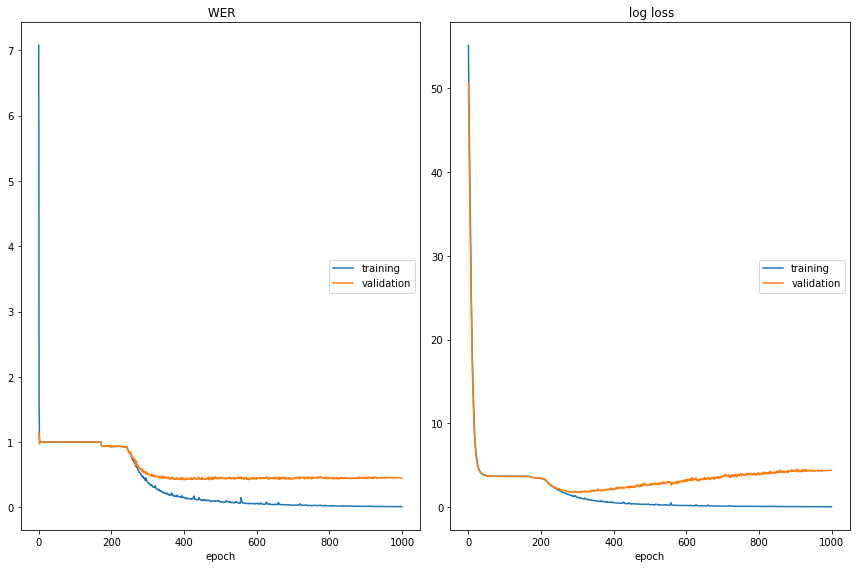

 WER
	training         	 (min:    0.010, max:    7.075, cur:    0.010)
	validation       	 (min:    0.422, max:    1.147, cur:    0.452)
 log loss
	training         	 (min:    0.033, max:   55.133, cur:    0.033)
	validation       	 (min:    1.746, max:   50.669, cur:    4.383)


In [48]:
model = deep_harmony(
    n_feats=105,
    n_rnn_layers=3,
    rnn_dim=64,
    rnn_hidden_size=64,
    cnn_kwargs=dict(n_cnn_layers=3, dropout=0.1, nonlinearity=nn.GELU))

if torch.cuda.is_available():
    model.cuda()

learning_rate = 1e-3
epochs=1000
weight_decay = 5e-4
optimizer = optim.AdamW(
    model.parameters(),
    lr=learning_rate,
    betas=(0.9, 0.999),
    weight_decay=weight_decay)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer=optimizer,
    max_lr=1e-3,
    steps_per_epoch=len(loader_train),
    epochs=epochs,
    anneal_strategy='linear',
)

solver = Solver(
    model=model,
    optimizer=optimizer,
    dataloaders=dataloaders,
    scheduler=scheduler,
    trained_model_name="deep_harmony_exp6_12.pth",
    epochs=epochs)
solver.train()

In [1]:
# Evaluate exp model

In [8]:
audio_processor = dataset.dataset.audio_processor
spec_dataset = dataset.dataset

model = deep_harmony(pretrained=True,
                     model_name="deep_harmony_exp6_12.pth",
                     n_feats=105,
                     n_rnn_layers=3,
                     rnn_dim=64,
                     rnn_hidden_size=64,
                     cnn_kwargs=dict(n_cnn_layers=3, dropout=0.1, nonlinearity=nn.GELU))

evaluate_dataset(
    dataset=spec_dataset,
    model=model,
    save_ann=True)

Process: <01-A_Hard_Day_s_Night>
Process: <02-I_Should_Have_Known_Better>
Process: <03-If_I_Fell>
Process: <04-I_m_Happy_Just_To_Dance_With_You>
Process: <05-And_I_Love_Her>
Process: <06-Tell_Me_Why>
Process: <07-Can_t_Buy_Me_Love>
Process: <08-Any_Time_At_All>
Process: <09-I_ll_Cry_Instead>
Process: <10-Things_We_Said_Today>
Process: <11-When_I_Get_Home>
Process: <12-You_Can_t_Do_That>
Process: <13-I_ll_Be_Back>
Process: <01-Come_Together>
Process: <02-Something>
Process: <03-Maxwell_s_Silver_Hammer>
Process: <04-Oh_Darling>
Process: <05-Octopus_s_Garden>
Process: <06-I_Want_You_She_s_So_Heavy_>
Process: <07-Here_Comes_The_Sun>
Process: <08-Because>
Process: <09-You_Never_Give_Me_Your_Money>
Process: <10-Sun_King>
Process: <11-Mean_Mr_Mustard>
Process: <12-Polythene_Pam>
Process: <13-She_Came_In_Through_The_Bathroom_Window>
Process: <14-Golden_Slumbers>
Process: <15-Carry_That_Weight>
Process: <16-The_End>
Process: <17-Her_Majesty>
Process: <01-No_Reply>
Process: <02-I_m_A_Loser>
Proc

Process: <12-Hot Fudge>
Process: <13-Cursed>
Process: <14a-Nan's Song>
Process: <14b-How Peculiar (Reprise)>
Process: <01-Ghosts>
Process: <02-Tripping>
Process: <03-Make Me Pure>
Process: <04-Spread Your Wings>
Process: <05-Advertising Space>
Process: <06-Please Don't Die>
Process: <07-Your Gay Friend>
Process: <08-Sin Sin Sin>
Process: <09-Random Acts Of Kindness>
Process: <10-The Trouble With Me>
Process: <11-A Place To Crash>
Process: <12-King Of Bloke And Bird>


In [11]:
print_ds_compute_average_scores('beatles')

	thirds:        0.116
	thirds_inv:    0.112
	triads:        0.113
	triads_inv:    0.110
	tetrads:       0.105
	tetrads_inv:   0.103
	root:          0.143
	mirex:         0.119
	majmin:        0.119
	majmin_inv:    0.116
	sevenths:      0.112
	sevenths_inv:  0.110
	underseg:      0.289
	overseg:       0.930
	seg:           0.286
